In [1]:
import math
import torch

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector

from mmcv.parallel import collate, scatter
from mmcv.ops import RoIPool
from mmcv import Config, DictAction
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.core.post_processing import fast_nms

import torch
import clip
from PIL import Image

/home/cry/anaconda3/envs/clip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# 从 model zoo 下载 checkpoint 并放在 `checkpoints/` 文件下
# 网址为: http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
# 初始化检测器
model = init_detector(config_file, checkpoint_file, device=device)

# 初始化零样本CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [6]:
cfg = Config.fromfile(config_file)

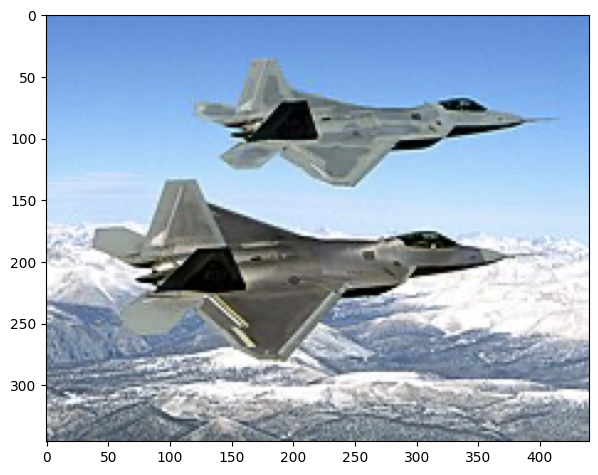

In [3]:
image_path = "images/F-22.png"
image = cv2.imread(image_path)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

/home/cry/data3/ZSOD_w_CLIP/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


4 object (119, 37, 416, 137) 0.97192323
4 object (52, 35, 411, 243) 0.6244976
4 object (25, 138, 407, 258) 0.57705164
4 object (117, 36, 225, 111) 0.50491357


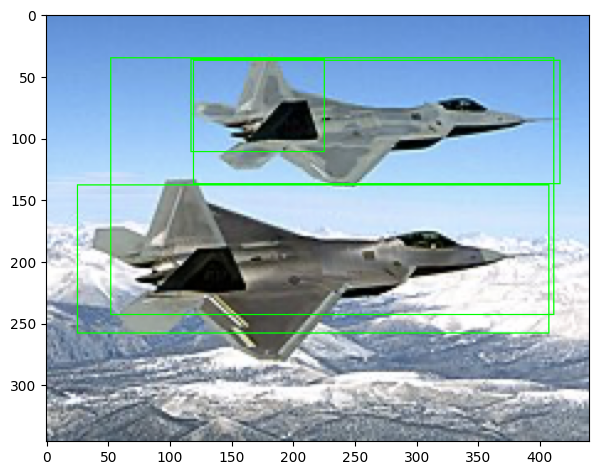

In [4]:
out = inference_detector(model, image)

boxes = []

res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.5:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, "object", box, score)
        boxes.append(box)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

In [7]:
image2 = Image.open(image_path)
cropped = image2.crop(boxes[0])

input = preprocess(cropped).unsqueeze(0).to(device)

In [8]:
text = clip.tokenize([
    "F-22",
    "Su-35",
    "Su-57"]).to(device)

In [9]:
with torch.no_grad():
    # image_features = clip_model.encode_image(input)
    # text_features = clip_model.encode_text(text)
    
    logits_per_image, logits_per_text = clip_model(input, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [10]:
print("Label probs:", probs)

Label probs: [[0.5576 0.0282 0.4143]]


In [11]:
probs.argmax()

0